In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics, preprocessing, model_selection
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42

In [3]:
df = pd.read_csv("data/zindi_paul.csv", index_col = 0)

df.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'weekday', 'hour', 'month', 'Date', 'transaction_day_cum', 'cum',
       'Amount_cum', 'amount_day_cum', 'amount_mean_day_cum'],
      dtype='object')

In [9]:
from scripts.functions import make_dummies

In [10]:
ls = ['ProductCategory', 'ChannelId','weekday','hour', 'PricingStrategy', 'ProviderId']

df = make_dummies(df, ls)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95662 entries, 0 to 95661
Data columns (total 65 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  int64  
 1   BatchId               95662 non-null  int64  
 2   AccountId             95662 non-null  int64  
 3   SubscriptionId        95662 non-null  int64  
 4   CustomerId            95662 non-null  int64  
 5   ProductId             95662 non-null  int64  
 6   Amount                95662 non-null  float64
 7   Value                 95662 non-null  int64  
 8   TransactionStartTime  95662 non-null  object 
 9   FraudResult           95662 non-null  int64  
 10  month                 95662 non-null  int64  
 11  Date                  95662 non-null  object 
 12  transaction_day_cum   95662 non-null  int64  
 13  cum                   95662 non-null  int64  
 14  Amount_cum            95662 non-null  float64
 15  amount_day_cum     

In [12]:
from scripts.functions import remove_columns

In [13]:
drop_list = ['ProductCategory', 'ChannelId', 'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'Value', 'TransactionStartTime', 'year',
       'month', "Date"]

df = remove_columns(df, drop_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95662 entries, 0 to 95661
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ProductId            95662 non-null  int64  
 1   Amount               95662 non-null  float64
 2   FraudResult          95662 non-null  int64  
 3   transaction_day_cum  95662 non-null  int64  
 4   cum                  95662 non-null  int64  
 5   Amount_cum           95662 non-null  float64
 6   amount_day_cum       95662 non-null  float64
 7   amount_mean_day_cum  95662 non-null  float64
 8   data_bundles         95662 non-null  uint8  
 9   financial_services   95662 non-null  uint8  
 10  movies               95662 non-null  uint8  
 11  other                95662 non-null  uint8  
 12  ticket               95662 non-null  uint8  
 13  transport            95662 non-null  uint8  
 14  tv                   95662 non-null  uint8  
 15  utility_bill         95662 non-null 

In [15]:
# split data into features and targets/labels

X = df.drop("FraudResult", axis = 1)
y = df.FraudResult

In [16]:
# Train test split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RSEED, stratify = y)

# Training XGBoost Using Non-Balanced Train Data

[18:55:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.95      0.90      0.92        58

    accuracy                           1.00     28699
   macro avg       0.97      0.95      0.96     28699
weighted avg       1.00      1.00      1.00     28699

Confusion matrix, without normalization
[[28638     3]
 [    6    52]]


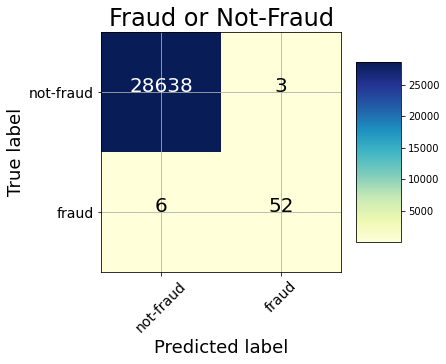

In [20]:
#XGBoost Training
xgb = XGBClassifier(use_label_encoder = False, n_estimators = 100)
test = xgb.fit(X_train, y_train)

# Make predictions on test set 
y_pred = xgb.predict(X_test)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

#import function from python scripts
from scripts.confusion_matrix import plot_confusion_matrix 

plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "Fraud or Not-Fraud")
#sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Balancing the Training Dataset

In [45]:
from imblearn.over_sampling import SMOTE #require the instalation imblearn library, available in requirement.txt
from imblearn import under_sampling, over_sampling

In [46]:
def balance_traindata(X_train, y_train):
    '''
    requires 2 parameters: X_train, y_train
    returns: X_train, y_train (with balanced y_train values)
    '''
    # Oversample data
    smote_algo = SMOTE(random_state=0)
    smote_data_X, smote_data_Y = smote_algo.fit_resample(X_train, y_train)
    smote_data_X = pd.DataFrame(data=smote_data_X, columns=X_train.columns)
    smote_data_Y = pd.DataFrame(data=smote_data_Y)
    # Join X and Y smote data into one
    smote_data = smote_data_X
    return smote_data, smote_data_Y[y_test.name]

In [44]:
#from scripts.functions import balance_traindata

In [47]:
X_trainB, y_trainB = balance_traindata(X_train, y_train)

In [89]:
print('Rows in X_train = ' + str(len(X_trainB)))
print('Rows in y_train = ' + str(len(y_trainB)))
print('Count of "0" in y_train = ' + str(y_trainB.value_counts()[0]))
print('Count of "1" in y_train = ' + str(y_trainB.value_counts()[1]))

Rows in X_train = 133656
Rows in y_train = 133656
Count of "0" in y_train = 66828
Count of "1" in y_train = 66828


In [108]:
X_trainB.columns

Index(['ProductId', 'Amount', 'transaction_day_cum', 'cum', 'Amount_cum',
       'amount_day_cum', 'amount_mean_day_cum', 'data_bundles',
       'financial_services', 'movies', 'other', 'ticket', 'transport', 'tv',
       'utility_bill', 'ChannelId_2', 'ChannelId_3', 'ChannelId_5',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'PricingStrategy_1', 'PricingStrategy_2', 'PricingStrategy_4',
       'ProviderId_2', 'ProviderId_3', 'ProviderId_4', 'ProviderId_5',
       'ProviderId_6'],
      dtype='object')

# XGBoost Model with Balanced Training Data

In [109]:
xgb = XGBClassifier(use_label_encoder = False, n_estimators = 100)
test = xgb.fit(X_trainB, y_trainB)

[18:35:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.81      0.95      0.87        58

    accuracy                           1.00     28699
   macro avg       0.90      0.97      0.94     28699
weighted avg       1.00      1.00      1.00     28699

Confusion matrix, without normalization
[[28628    13]
 [    3    55]]


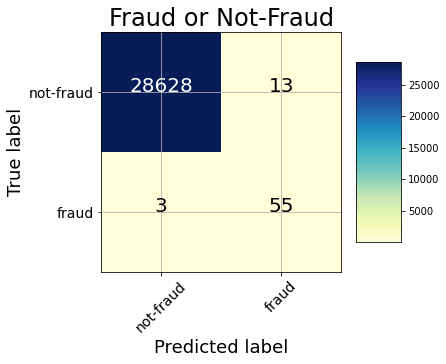

In [94]:
# Make predictions on test set 
y_pred = xgb.predict(X_test)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

#import function from python scripts
from confusion_matrix import plot_confusion_matrix 

plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "Fraud or Not-Fraud")
#sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Model Randomforest with Balanced Train Data

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.84      0.74      0.79        58

    accuracy                           1.00     28699
   macro avg       0.92      0.87      0.89     28699
weighted avg       1.00      1.00      1.00     28699

Confusion matrix, without normalization
[[28633     8]
 [   15    43]]


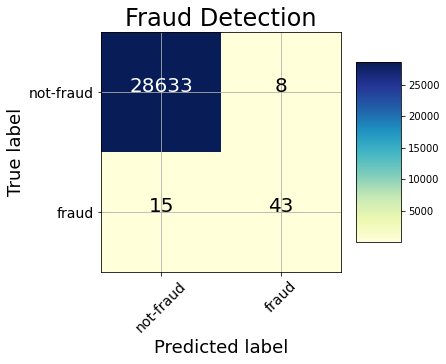

In [96]:
rdm = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt', # the sqrt from the numbers 
                               n_jobs=-1, verbose = 1) 

rdm_model = rdm.fit(X_trainB, y_trainB)
y_pred = rdm.predict(X_test)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

from confusion_matrix import plot_confusion_matrix #import function from script
plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "Fraud Detection");

warnings.filterwarnings('ignore')

In [99]:
# Hyperparameter grid 
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
rdm = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rdm_grid = RandomizedSearchCV(rdm, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)
rdm_model = rdm_grid.fit(X_trainB, y_trainB)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 